# Building a general purpose chatbot

In this practical exercise, The goal will be to implement the different tasks in a general purpose chatbot.



In [3]:
!gdown --id 1JipPFr14hWBoQ0tnEJyTrOh5RoGFhaf3
!gdown --id 12DkcmwEEuitna9XJNYD9mBhDdaTzsWcS
!gdown --id 1iU73m8iDxEcqAmmLc4i_cudFOWJQMORY

/bin/bash: gdown: command not found
/bin/bash: gdown: command not found


/bin/bash: gdown: command not found


In [4]:
import pandas as pd

train_df = pd.read_csv('/Users/juliencardi/Documents/SCIAG/exam/content/train.csv')
val_df = pd.read_csv('/Users/juliencardi/Documents/SCIAG/exam/content/val.csv')
intent_responses = pd.read_csv('/Users/juliencardi/Documents/SCIAG/exam/content/intent_response.csv')

train_df.head()

,sentence,intent
0,what expression would i use to say i love you ...,translate
1,can you tell me how to say 'i do not speak muc...,translate
2,"what is the equivalent of, 'life is good' in f...",translate
3,"tell me how to say, 'it is a beautiful morning...",translate
4,"if i were mongolian, how would i say that i am...",translate


The dataset has a 100 examples for many intents ('translate', 'transfer', 'timer', 'definition', 'meaning_of_life',
 'insurance_change', 'find_phone', 'travel_alert', 'pto_request'...).

The goal will be to build a general purpose assistant that detects the user intent and relevant entities and provides generic answers.


## 1) EDA

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliencardi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of classes: 151
Number of examples in the training set: 15100


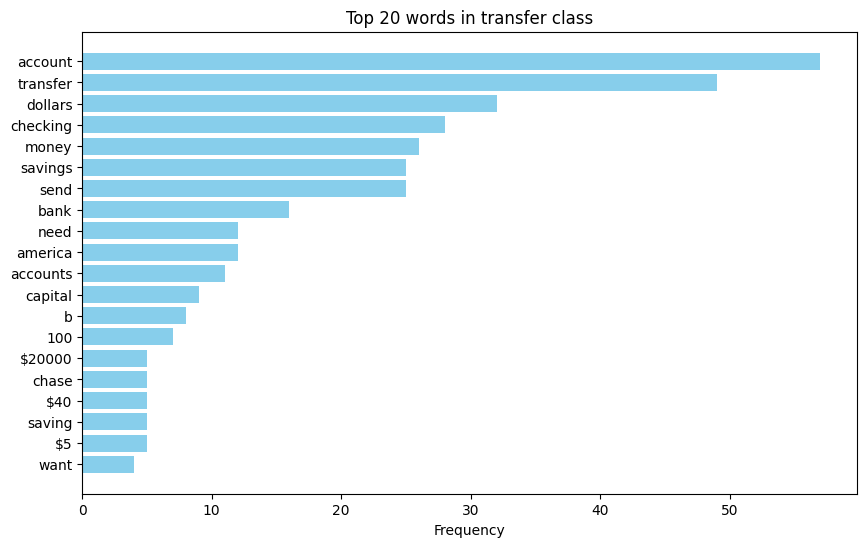

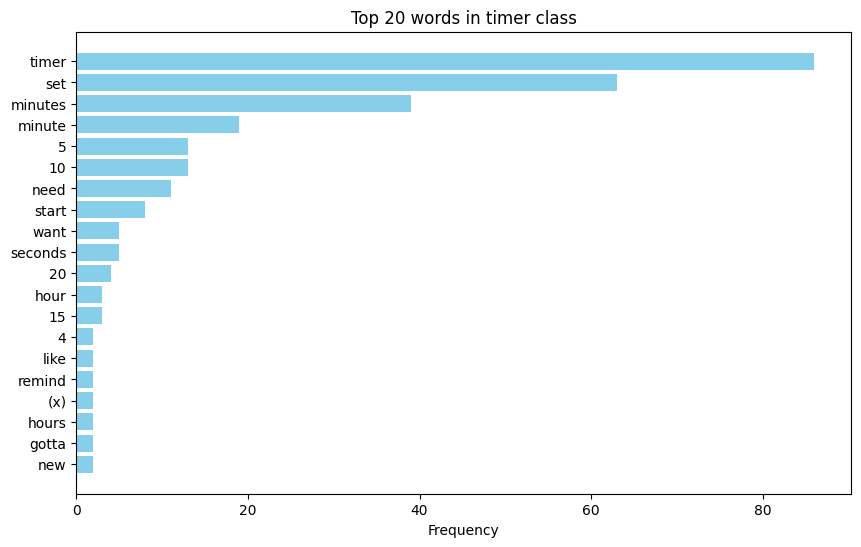

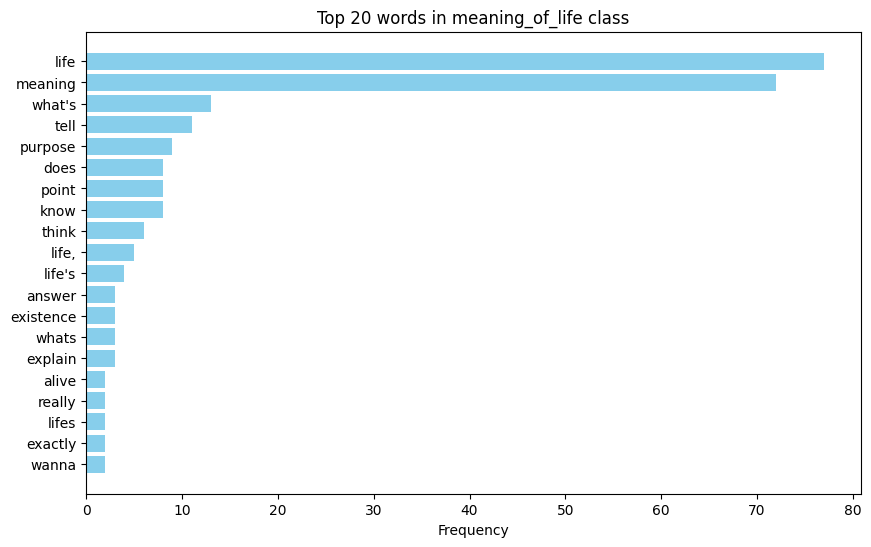

Average number of words in the sentences: 8.547152317880794


In [5]:

# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize



# 1) Count the number of classes and examples in the training set
print("Number of classes:", train_df['intent'].nunique())
print("Number of examples in the training set:", len(train_df))

# 2) Display histograms for 'transfer', 'timer', 'meaning_of_life'
def plot_top_words(class_name):
    texts = train_df[train_df['intent'] == class_name]['sentence']
    all_words = ' '.join(texts).lower().split()
    all_words = [word for word in all_words if word not in ENGLISH_STOP_WORDS]
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(20)
    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 20 words in {class_name} class')
    plt.gca().invert_yaxis()
    plt.show()

# Plot for each specified class
for intent in ['transfer', 'timer', 'meaning_of_life']:
    plot_top_words(intent)

# 3) Calculate the average number of words in the sentences
train_df['word_count'] = train_df['sentence'].apply(lambda x: len(word_tokenize(x)))
average_word_count = train_df['word_count'].mean()
print("Average number of words in the sentences:", average_word_count)


Le nombre moyen de mot est de 8.55

## 2) Data preparation:

In [6]:


# Additional imports for data preparation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

# Function to clean and lemmatize sentences
def clean_text(sentence):
    doc = nlp(sentence)
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in STOP_WORDS and token not in string.punctuation:
            cleaned_tokens.append(token)
    
    return " ".join(cleaned_tokens)

# Apply the cleaning function to the sentence column
train_df['processed_sentence'] = train_df['sentence'].apply(clean_text)
val_df['processed_sentence'] = val_df['sentence'].apply(clean_text)

# Separate the class 'oos' from the datasets
train_df_oos = train_df[train_df['intent'] == 'oos']
val_df_oos = val_df[val_df['intent'] == 'oos']

# Remove 'oos' examples from original datasets
train_df = train_df[train_df['intent'] != 'oos']
val_df = val_df[val_df['intent'] != 'oos']

# Displaying the first few rows to verify the processed data
print(train_df.head())
print(val_df.head())
print(train_df_oos.head())
print(val_df_oos.head())


                                            sentence     intent  word_count  \
0  what expression would i use to say i love you ...  translate          15   
1  can you tell me how to say 'i do not speak muc...  translate          18   
2  what is the equivalent of, 'life is good' in f...  translate          12   
3  tell me how to say, 'it is a beautiful morning...  translate          14   
4  if i were mongolian, how would i say that i am...  translate          14   

               processed_sentence  
0     expression use love italian  
1      tell speak spanish spanish  
2     equivalent life good french  
3  tell beautiful morning italian  
4               mongolian tourist  
                                    sentence     intent     processed_sentence
0   in spanish, meet me tomorrow is said how  translate  spanish meet tomorrow
1     in french, how do i say, see you later  translate           french later
2           how do you say hello in japanese  translate         hello ja

## 3) Topic modeling:

In [24]:


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

# 1) Build the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['sentence'])

# 2) Run LSA
lsa = TruncatedSVD(n_components=20, random_state=42)
X_train_lsa = lsa.fit_transform(X_train_tfidf)

# Function to display the topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}: ")
        print(" ".join([feature_names[i] + " (" + str(round(topic[i], 2)) + ")"
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# 3) Display the obtained topics
display_topics(lsa, tfidf_vectorizer.get_feature_names_out(), 5)

# 4) Display all the distinct intents from `train_df`
print("Distinct intents from train_df:")
print(train_df['intent'].unique())






Topic 1: 
card (0.48) credit (0.42) need (0.34) know (0.3) tell (0.29)
Topic 2: 
need (0.4) change (0.34) oil (0.3) know (0.27) car (0.22)
Topic 3: 
tell (0.87) list (0.21) shopping (0.13) date (0.05) today (0.05)
Topic 4: 
change (0.5) oil (0.41) car (0.21) tell (0.12) credit (0.11)
Topic 5: 
list (0.65) shopping (0.43) change (0.22) oil (0.18) add (0.11)
Topic 6: 
need (0.49) car (0.2) card (0.14) gas (0.13) visa (0.12)
Topic 7: 
account (0.56) need (0.3) bank (0.29) number (0.16) checking (0.12)
Topic 8: 
car (0.65) gas (0.35) does (0.26) account (0.17) use (0.12)
Topic 9: 
credit (0.49) score (0.43) need (0.23) car (0.15) limit (0.15)
Topic 10: 
time (0.68) vacation (0.33) set (0.22) days (0.21) request (0.16)
Topic 11: 
song (0.38) phone (0.38) want (0.37) set (0.32) help (0.22)
Topic 12: 
phone (0.67) help (0.22) time (0.12) lost (0.1) disconnect (0.09)
Topic 13: 
song (0.73) playlist (0.24) play (0.19) time (0.17) need (0.14)
Topic 14: 
like (0.6) time (0.22) phone (0.11) date (

The topics identified by the LSA analysis indeed seem to reflect a number of actual intents present in the training dataset. For example, topic 1, which focuses on credit cards, could be related to several intents associated with credit card management, such as credit_score, new_card, or report_lost_card. Similarly, topic 2, which includes terms like "change," "oil," and "car," accurately reflects intents such as oil_change_how and schedule_maintenance.

## 4) Classification:

CountVectorizer 'sentence' selected
Les paires d'intentions les plus confondues sont: ('damaged_card', 'card_declined')


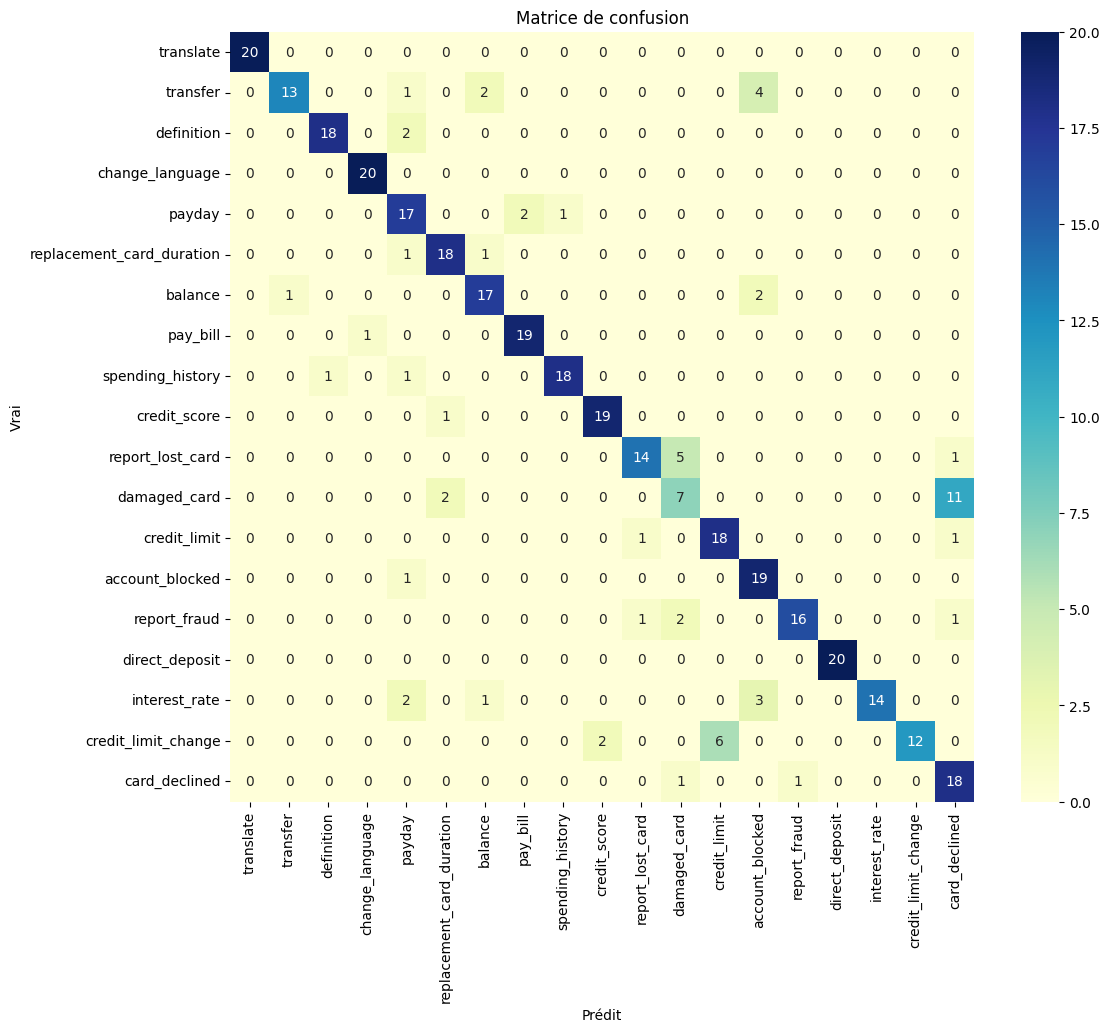

In [25]:


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Définir les vecteurs pour BoW et TF-IDF
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Préparation des matrices BoW pour 'sentence' et 'processed_sentence'
X_train_counts_sentence = count_vectorizer.fit_transform(train_df['sentence'])
X_val_counts_sentence = count_vectorizer.transform(val_df['sentence'])
X_train_counts_processed = count_vectorizer.fit_transform(train_df['processed_sentence'])
X_val_counts_processed = count_vectorizer.transform(val_df['processed_sentence'])

# Préparation des matrices TF-IDF pour 'sentence' et 'processed_sentence'
X_train_tfidf_sentence = tfidf_vectorizer.fit_transform(train_df['sentence'])
X_val_tfidf_sentence = tfidf_vectorizer.transform(val_df['sentence'])
X_train_tfidf_processed = tfidf_vectorizer.fit_transform(train_df['processed_sentence'])
X_val_tfidf_processed = tfidf_vectorizer.transform(val_df['processed_sentence'])

# Initialisation et entraînement des modèles de régression logistique pour BoW 'sentence' et 'processed_sentence'
lr_counts_sentence = LogisticRegression(max_iter=1000)
lr_counts_sentence.fit(X_train_counts_sentence, train_df['intent'])
lr_counts_processed = LogisticRegression(max_iter=1000)
lr_counts_processed.fit(X_train_counts_processed, train_df['intent'])

# Initialisation et entraînement des modèles de régression logistique pour TF-IDF 'sentence' et 'processed_sentence'
lr_tfidf_sentence = LogisticRegression(max_iter=1000)
lr_tfidf_sentence.fit(X_train_tfidf_sentence, train_df['intent'])
lr_tfidf_processed = LogisticRegression(max_iter=1000)
lr_tfidf_processed.fit(X_train_tfidf_processed, train_df['intent'])

# Prédictions et évaluations pour BoW 'sentence' et 'processed_sentence'
y_pred_counts_sentence = lr_counts_sentence.predict(X_val_counts_sentence)
y_pred_counts_processed = lr_counts_processed.predict(X_val_counts_processed)

# Prédictions et évaluations pour TF-IDF 'sentence' et 'processed_sentence'
y_pred_tfidf_sentence = lr_tfidf_sentence.predict(X_val_tfidf_sentence)
y_pred_tfidf_processed = lr_tfidf_processed.predict(X_val_tfidf_processed)

# Calcul des scores
accuracy_counts_sentence = accuracy_score(val_df['intent'], y_pred_counts_sentence)
f1_counts_sentence = f1_score(val_df['intent'], y_pred_counts_sentence, average='micro')
accuracy_counts_processed = accuracy_score(val_df['intent'], y_pred_counts_processed)
f1_counts_processed = f1_score(val_df['intent'], y_pred_counts_processed, average='micro')
accuracy_tfidf_sentence = accuracy_score(val_df['intent'], y_pred_tfidf_sentence)
f1_tfidf_sentence = f1_score(val_df['intent'], y_pred_tfidf_sentence, average='micro')
accuracy_tfidf_processed = accuracy_score(val_df['intent'], y_pred_tfidf_processed)
f1_tfidf_processed = f1_score(val_df['intent'], y_pred_tfidf_processed, average='micro')

# Sélection automatique de la meilleure approche
scores = {
    'tfidf_sentence': accuracy_tfidf_sentence + f1_tfidf_sentence,
    'tfidf_processed': accuracy_tfidf_processed + f1_tfidf_processed,
    'count_sentence': accuracy_counts_sentence + f1_counts_sentence,
    'count_processed': accuracy_counts_processed + f1_counts_processed
}
best_approach = max(scores, key=scores.get)

if best_approach == 'tfidf_sentence':
    best_vectorizer = tfidf_vectorizer
    best_lr_model = lr_tfidf_sentence
    print("TF-IDF 'sentence' selected")
elif best_approach == 'tfidf_processed':
    best_vectorizer = tfidf_vectorizer
    best_lr_model = lr_tfidf_processed
    print("TF-IDF 'processed_sentence' selected")
elif best_approach == 'count_sentence':
    best_vectorizer = count_vectorizer
    best_lr_model = lr_counts_sentence
    print("CountVectorizer 'sentence' selected")
else:
    best_vectorizer = count_vectorizer
    best_lr_model = lr_counts_processed
    print("CountVectorizer 'processed_sentence' selected")

# Entraînement sur un sous-ensemble d'intentions
subset_intents = ['translate', 'transfer', 'definition', 'change_language', 'payday', 'replacement_card_duration',
                  'balance', 'pay_bill', 'spending_history', 'credit_score', 'report_lost_card', 'damaged_card',
                  'credit_limit', 'account_blocked', 'report_fraud', 'direct_deposit', 'interest_rate',
                  'credit_limit_change', 'card_declined']

train_subset = train_df[train_df['intent'].isin(subset_intents)]
val_subset = val_df[val_df['intent'].isin(subset_intents)]

X_train_subset = best_vectorizer.transform(train_subset['sentence'])
X_val_subset = best_vectorizer.transform(val_subset['sentence'])

best_lr_model.fit(X_train_subset, train_subset['intent'])

# Prédiction et matrice de confusion sur le sous-ensemble
y_pred_subset = best_lr_model.predict(X_val_subset)
cm = confusion_matrix(val_subset['intent'], y_pred_subset, labels=subset_intents)

# Affichage de la matrice de confusion
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.title('Matrice de confusion')

plot_confusion_matrix(cm, subset_intents)

# Identification des paires d'intentions les plus confondues
def find_most_confused_pairs(cm, labels):
    np.fill_diagonal(cm, 0)
    index = np.unravel_index(np.argmax(cm, axis=None), cm.shape)
    return labels[index[0]], labels[index[1]]

most_confused = find_most_confused_pairs(cm, subset_intents)
print("Les paires d'intentions les plus confondues sont:", most_confused)


('damaged_card','card_declined') ('credit_limit', 'credit_limit_change') ('account_blocked','transfer') sont les paires les plus confondus


## 5) Named Entity Recognition:

In [27]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from spacy.language import Language
import random

# Load the English model
nlp = spacy.load("en_core_web_sm")

# Specified intents
intents = ["change_user_name", "time", "change_language", "pto_request", "travel_alert", "timer", "translate"]

for intent in intents:
    print(f"Intent: {intent}")
    samples = train_df[train_df['intent'] == intent].sample(10)['sentence']
    for sentence in samples:
        print(sentence)
    print("\n")

# Instantiate the PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
languages = ["English", "Spanish", "French", "German", "Chinese"]
language_patterns = [nlp.make_doc(text) for text in languages]
matcher.add("LANGUAGE", language_patterns)

countries = ["France", "Spain", "Germany", "China", "India"]
country_patterns = [nlp.make_doc(text) for text in countries]
matcher.add("COUNTRY", country_patterns)

dates = ["today", "tomorrow", "yesterday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
date_patterns = [nlp.make_doc(text) for text in dates]
matcher.add("DATE", date_patterns)

# Custom component for adding entities
@Language.component("custom_entities")
def add_custom_entities(doc):
    matches = matcher(doc)
    new_ents = []
    for match_id, start, end in matches:
        # Create a Span for the match
        span = Span(doc, start, end, label=match_id)
        # Only add the new entity if it doesn't overlap with existing ones
        if not any(span.start < ent.end and span.end > ent.start for ent in doc.ents):
            new_ents.append(span)
    # Apply the filtered entities
    doc.ents = list(doc.ents) + new_ents
    return doc

# Add the custom component to the pipeline
nlp.add_pipe("custom_entities", after="ner")

# Display entities for the first ten sentences of the relevant intents
for intent in intents:
    print(f"Intent: {intent}")
    samples = train_df[train_df['intent'] == intent].head(10)['sentence']
    for sentence in samples:
        doc = nlp(sentence)
        print(f"Sentence: {sentence}")
        print("Entities:", [(ent.text, ent.label_) for ent in doc.ents])
    print("\n")


Intent: change_user_name
call me dad
i want to be called mollie
can i have you call me something else
you can call me john
i am john
call me ishmael
call me frank
i want to be called by mary
you can refer to me as frank
i go by stefan


Intent: time
what's the time right now
what time is it in paris
what time is it now pacific time
current time, please
what time is it exactly in the new zealand time zone
what is the time in atlantic timezone
what's the current time in greenwhich
what time do you have on your watch
what time is it in fredericksburg, tx
what time is it in houston, tx


Intent: change_language
can you talk to me in french
i need to change language to spanish
alter your language to french
set your language setting to english
change language to french, please
change the response language to french please
please speak to me in chinese
how can i adjust the spoken language
change your spoken language to english
i will be speaking chinese going forward


Intent: pto_request
how

I sometimes get empty entities, but generally, the entities seem to align with the intent. For example, for the timer intent, I get time-based entities like [('4 minutes', 'TIME')] or [('thirty minutes', 'TIME')]. For the time intent, I get locations like [('florida', 'GPE')], etc.

In [10]:
!pip install geonamescache
!pip install pycountry

/bin/bash: pip: command not found
/bin/bash: pip: command not found


In [11]:
# getting a list of countries  using pycountry
import pycountry
countries = [x.name for x in list(pycountry.countries)]

In [12]:
# hard coded languages
languages = [
    "English",
    "Spanish",
    "French",
    "German",
    "Chinese",
    "Hindi",
    "Arabic",
    "Bengali",
    "Russian",
    "Portuguese",
    "Japanese",
    "Punjabi",
    "Bengali",
    "Telugu",
    "Marathi",
    "Tamil",
    "Urdu",
    "Turkish",
    "Italian",
    "Vietnamese",
    "Korean",
    "Thai",
    "Malay",
    "Persian",
    "Polish",
    "Cantonese",
    "Ukrainian",
    "Romanian",
    "Dutch",
    "Swedish",
    "Gujarati",
    "Indonesian",
    "Greek",
    "Czech",
    "Hebrew",
    "Danish",
    "Norwegian",
    "Finnish",
    "Hungarian",
    "Slovak",
    "Bulgarian",
    "Croatian",
    "Serbian",
    "Slovenian",
    "Lithuanian",
    "Latvian",
    "Estonian",
    "Kazakh",
    "Georgian",
    "Tatar",
    "Kyrgyz",
    "Belarusian",
    "Mongolian",
    "Azerbaijani",
    "Uzbek",
    "Tajik",
    "Turkmen",
    "Armenian",
    "Bosnian",
    "Albanian",
    "Macedonian",
    "Montenegrin",
    "Bislama",
    "Fijian",
    "Hawaiian",
    "Samoan",
    "Tongan",
    "Tahitian",
    "Marshallese",
    "Palauan",
    "Chamorro"
]

## 6) Chatbot:

In [29]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")



# Fonction pour prédire l'intention en utilisant le modèle déjà entraîné
def predict_intent(sentence, model, vectorizer):
    transformed_sentence = vectorizer.transform([sentence])
    intent = model.predict(transformed_sentence)[0]
    return intent

# Fonction pour extraire les entités en utilisant SpaCy
def extract_entities(sentence):
    doc = nlp(sentence)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Boucle de chat qui utilise le modèle entraîné et le DataFrame des réponses
def chatbot(model, vectorizer, responses_df):
    while True:
        user_input = input("Vous: ")
        if user_input.lower() == 'quit':
            print("Chatbot: Au revoir !")
            break
        
        intent = predict_intent(user_input, model, vectorizer)
        entities = extract_entities(user_input)
        response = responses_df[responses_df['intent'] == intent]['response'].values[0] if responses_df[responses_df['intent'] == intent]['response'].values.size > 0 else "Désolé, je ne comprends pas votre demande."
        
        print(f"Intent: {intent}")
        print(f"Entities: {entities}")
        print(f"Chatbot: {response}")

# Exécution du chatbot
chatbot(best_lr_model, best_vectorizer, intent_responses)


Intent: change_language
Entities: [('Spanish', 'NORP')]
Chatbot: I can assist you in changing the language settings.
Chatbot: Au revoir !
